---
**Market Basket Analysis**

*Which products will an Instacart consumer purchase again?*

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/06/kaggle-logo-transparent-300.png" width="300"> 
<img src="https://www.getpeanutbutter.com/wp-content/uploads/2019/09/instacart-logo_v3.png" width="200">&emsp;

---

In [ ]:
!mkdir /root/.kaggle; mv /content/kaggle.json /root/.kaggle; chmod 600 /root/.kaggle/kaggle.json
!mkdir /content/InstaCart; kaggle competitions download -c instacart-market-basket-analysis -p /content/InstaCart -qq

!unzip -qq -a /content/InstaCart/aisles.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/departments.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/order_products__prior.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/order_products__train.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/orders.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/products.csv.zip -d /content/InstaCart/
!unzip -qq -a /content/InstaCart/sample_submission.csv.zip -d /content/InstaCart/

!rm -rf /content/InstaCart/*csv.zip

# Libraries and Data Importation 
---

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
os.chdir('/content/InstaCart/')

!pip install mlxtend --upgrade --no-deps -qq
!pip install squarify pywaffle -qq
import squarify
from pywaffle import Waffle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Files and their content

In [ ]:
columns=[]
content=[]
for csv in tqdm(os.listdir()):
  if csv.endswith('.csv') and not csv.startswith('sample'):
    content.append([i for i in pd.read_csv(csv).columns.tolist()])
    columns.append(csv)
pd.DataFrame(sorted(content), index=sorted(columns)).T

# Data Visualisation

## Let's look at the *Products*, *Departments* and *Aisles*

### Merge *Products*, *Departments*, and *Aisles* together into a dataframe to explore them. 

In [ ]:
products=pd.read_csv('products.csv').merge(pd.read_csv('aisles.csv'), on='aisle_id').merge(pd.read_csv('departments.csv'), on='department_id')
products.drop(['aisle_id', 'department_id'], 1, inplace=True)
products.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


### Waffle Chart to represent the Product Distribution in each Department

In [ ]:
fig = plt.figure( 
    FigureClass = Waffle, 
    rows = 10, 
    values = round(products.department.value_counts()/100), 
    labels = products.department.value_counts().index.tolist(), 
    legend={'loc': 'center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 5, 'framealpha': 0, 'fontsize':15}, 
    dpi=100, figsize=(20, 10))

### Count Plot to show Aisle-wise distribution of Departments.

In [ ]:
grouped_df = products.groupby('department')
fig, axes = plt.subplots(nrows=10, ncols=2, dpi=100, figsize=(40, 60))
for key, ax in zip(grouped_df.groups.keys(), axes.flatten()):
  group = grouped_df.get_group(key).aisle.value_counts(sort=True).reset_index()
  sns.barplot(y = 'index', x = 'aisle', 
                data = group, 
                ax=ax, palette='muted')
  ax.set_title(f"Aisle: {key.title()}", fontsize=15, fontstyle='oblique')
  ax.set_yticklabels([i.get_text().title() for i in ax.get_yticklabels()], fontsize=15)
  ax.set_ylabel(None)
  ax.set_xlabel(None)
  ax.set_xticklabels([])

  for i, value in group.iterrows():
    ax.text(x=20, y=i, s=value.aisle, verticalalignment='center', fontsize=15, fontstyle='oblique')

fig.tight_layout(h_pad=2.5)
fig.suptitle(t="Which Department is in this Aisle", fontsize=35, fontstyle='oblique', x=0.5, y=1.01)



### Treemap for Product Distribution in each Department

In [ ]:
department = products.groupby('department').size().reset_index(name='counts')

plt.figure(figsize=(20,10), dpi= 100)
squarify.plot(label=[i.title() for i in department.department], 
              sizes=department.counts**0.5, 
              color = [plt.cm.Spectral(i/float(department.shape[0])) for i in range(department.shape[0])])

plt.axis('off')

## Now let's explore the *Users* and their *Orders*

In [ ]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Distribution of Orders *Day of the Week* vs. *Time of the Day*

In [ ]:
f, a = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), dpi=100)
sns.countplot(x = "order_dow", data=orders, ax=a[0], palette='muted')
sns.countplot(x = "order_hour_of_day", data=orders, ax=a[1], palette='muted')

In [ ]:
day_time_orders = pd.crosstab(orders.order_hour_of_day, orders.order_dow, normalize='columns')
day_time_orders.index = [pd.to_datetime(i, format='%H').time() for i in range(24)]
day_time_orders.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_time_orders.head()

plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(data = day_time_orders, cmap='coolwarm', robust=True)

## Lastly, exploring the *shopping list*

In [ ]:
train_order_cart = pd.merge(orders[orders.eval_set=='train'], pd.read_csv('order_products__train.csv'), on='order_id')
prior_order_cart = pd.merge(orders[orders.eval_set=='prior'], pd.read_csv('order_products__prior.csv'), on='order_id')
product_orders = pd.concat([train_order_cart, prior_order_cart], axis=0)
product_orders = pd.merge(product_orders, products, on='product_id')

product_orders.drop(['add_to_cart_order',	'reordered', 'eval_set', 'order_dow',	'order_hour_of_day', 'days_since_prior_order'], axis=1, inplace=True)
product_orders.head()

,order_id,user_id,order_number,product_id,product_name,aisle,department
0,1187899,1,11,196,Soda,soft drinks,beverages
1,2757217,67,25,196,Soda,soft drinks,beverages
2,632715,676,12,196,Soda,soft drinks,beverages
3,1167274,760,5,196,Soda,soft drinks,beverages
4,3347074,804,16,196,Soda,soft drinks,beverages


# Customer Segmentation

In [ ]:
cust_seg = pd.merge(pd.read_csv('order_products__train.csv'), products, on='product_id')
cust_seg = pd.merge(cust_seg, orders[orders.eval_set=='train'], on='order_id')

cust_seg.drop(['order_id', 'product_id', 'add_to_cart_order', 
               'reordered', 'eval_set', 'order_number', 
               'order_dow', 'order_hour_of_day', 'days_since_prior_order'], 
              axis=1, inplace=True)
cust_seg.drop_duplicates(inplace=True)
cust_seg.head()

,product_name,aisle,department,user_id
0,Bulgarian Yogurt,yogurt,dairy eggs,112108
1,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs,112108
2,Organic Celery Hearts,fresh vegetables,produce,112108
3,Cucumber Kirby,fresh vegetables,produce,112108
4,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,112108


In [ ]:
f"There are {cust_seg.department.nunique()} Departments with {cust_seg.product_name.nunique()} Products along {cust_seg.aisle.nunique()} Aisles with a customer base of {cust_seg.user_id.nunique()}"

'There are 21 Departments with 39123 Products along 134 Aisles with a customer base of 131209'

In [ ]:
cust_seg.product_name.value_counts().nlargest(10)

Banana                    18726
Bag of Organic Bananas    15480
Organic Strawberries      10894
Organic Baby Spinach       9784
Large Lemon                8135
Organic Avocado            7409
Organic Hass Avocado       7293
Strawberries               6494
Limes                      6033
Organic Raspberries        5546
Name: product_name, dtype: int64

In [ ]:
cust_seg.department.value_counts().nlargest(10)

produce            409087
dairy eggs         217051
snacks             118862
beverages          114046
frozen             100426
pantry              81242
bakery              48394
canned goods        46799
deli                44291
dry goods pasta     38713
Name: department, dtype: int64

In [ ]:
cust_seg.aisle.value_counts().nlargest(10)

fresh vegetables                 150609
fresh fruits                     150473
packaged vegetables fruits        78493
yogurt                            55240
packaged cheese                   41699
water seltzer sparkling water     36617
milk                              32644
chips pretzels                    31269
soy lactosefree                   26240
bread                             23635
Name: aisle, dtype: int64

### CrossTabulated Dataframe of Users and Aisles

In [ ]:
cust_aisle = pd.crosstab(cust_seg.user_id, cust_seg.aisle)
cust_aisle.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0


### Using **Principal Component Analysis** as a dimensionality reduction method

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)

In [ ]:
pca_aisle = pd.DataFrame(pca.fit_transform(cust_aisle))
pca_aisle.head()

,0,1,2,3,4,5
0,-1.585968,-0.068665,1.013526,-0.235316,0.354724,-0.093216
1,1.941122,5.166711,-1.604443,-0.863066,2.860719,-0.724391
2,0.074848,-0.008703,-0.265348,1.375263,-0.590792,0.089039
3,-1.172812,0.391134,-0.402276,-0.261598,0.208081,-0.193106
4,6.420225,-4.774948,-0.290913,-0.606770,-0.416930,-0.000363


### PairPlot to show Distribution of PCA components

In [ ]:
sns.pairplot(pca_aisle, diag_kind=None, height=10, aspect=1.5)

### Generating Combinations of PCA Components and segregating into 4 Clusters

In [ ]:
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
f, a = plt.subplots(nrows=5, ncols=3, figsize=(15, 10), dpi=100)
for ax, combo in tqdm(zip(a.flatten(), list(combinations(pca_aisle.columns.tolist(), 2)))):
  tocluster = pd.DataFrame(pca_aisle[list(combo)].values, columns=['PCA1', 'PCA2'])
  clusterer = KMeans(n_clusters=4, init='k-means++', n_jobs=-1).fit(tocluster)
  tocluster['Cluster'] = clusterer.predict(tocluster)
  sns.scatterplot(data=tocluster, x= 'PCA1', y= 'PCA2', hue= 'Cluster', palette='coolwarm', ax=ax)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_xticklabels('')
  ax.set_yticklabels('')
  ax.set_title(f"PCA Feature:\n{combo[0]} Vs. {combo[-1]}")
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='center', bbox_to_anchor = (1.1, 0.5), bbox_transform = plt.gcf().transFigure)

### PCA Component **1 vs. 4**
From the above PairPlot, we assume that the mentioned components have the most stable distribution. Hence, using the same to build a *Customer Segmentation* Model.

In [ ]:
tocluster = pd.DataFrame(pca_aisle[[4,1]].values, columns=['PCA1', 'PCA2'])

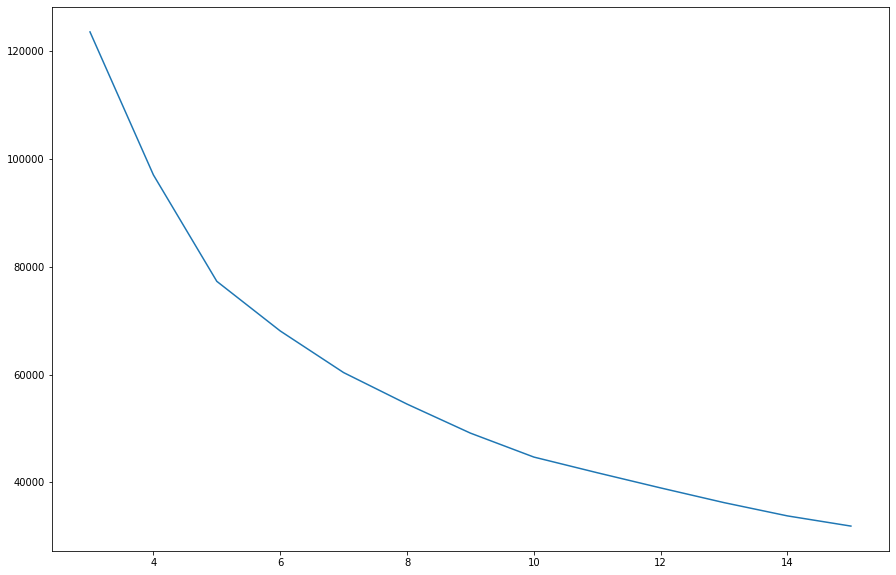

In [ ]:
wc = {}
for i in tqdm(range(3, 16)):
  clusterer = KMeans(n_clusters= i, init='k-means++', n_jobs=-1)
  cluster_labels = clusterer.fit_predict(tocluster)
  wc.update({i : clusterer.inertia_})

plt.figure(figsize=(15,10))
sns.lineplot(x = list(wc.keys()), y=list(wc.values()))

In [ ]:
clusterer = KMeans(n_clusters= 5, init='k-means++', n_jobs=-1)
cluster_labels = clusterer.fit_predict(tocluster)
cust_aisle['Cluster'] = cluster_labels
cust_aisle.head()
# print(silhouette_score(tocluster.iloc[:, :-1].values, cluster_labels), clusterer.inertia_)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
5,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,4


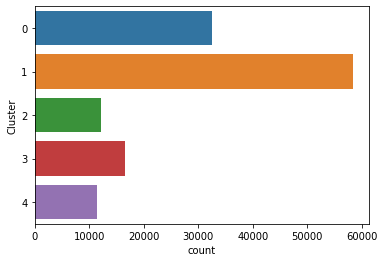

In [ ]:
sns.countplot(data= cust_aisle.reset_index(), y= 'Cluster')

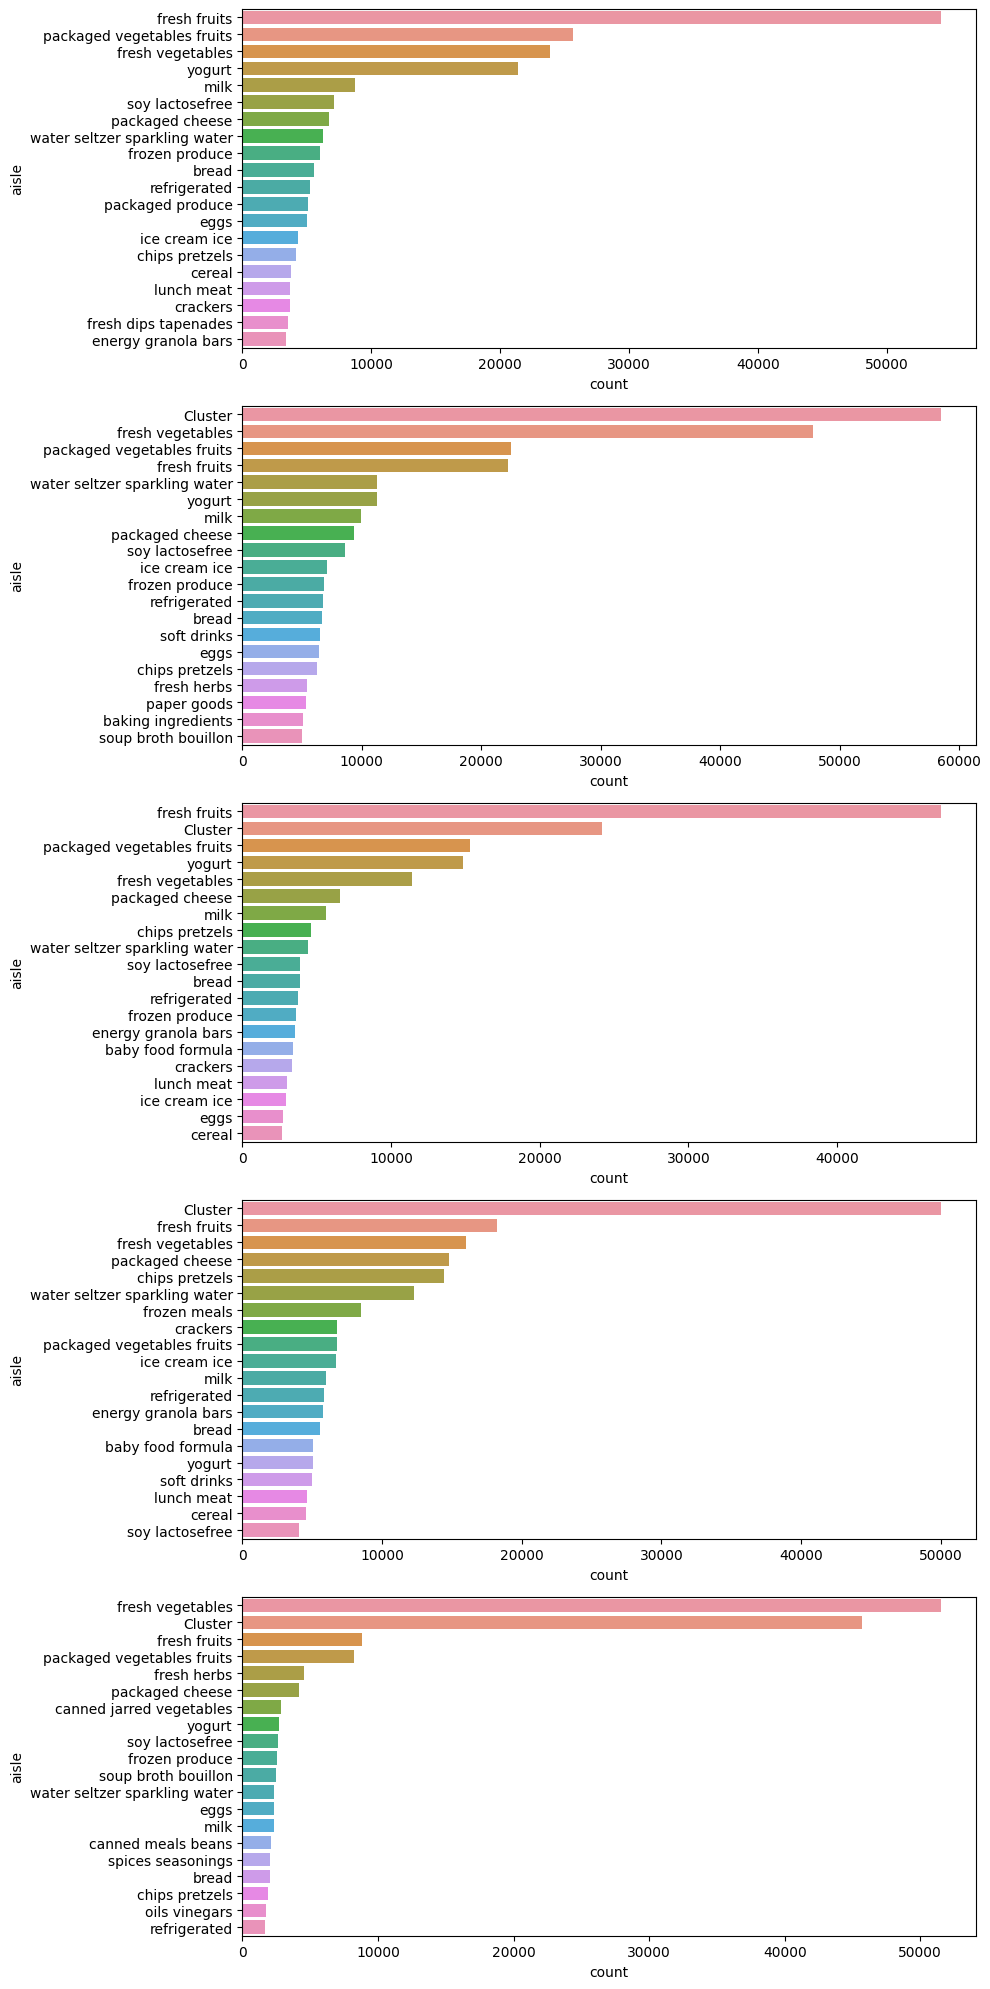

In [ ]:
clust = cust_aisle.groupby('Cluster')
f, a = plt.subplots(nrows=5, sharex=False, figsize=(10, 20), dpi=100)
for k, ax in zip(clust.groups.keys(), a.flatten()):
  sns.barplot(data = clust.get_group(k).sum().nlargest(20).reset_index(name='count'), x='count', y = 'aisle', ax=ax)
plt.tight_layout()

### WordClouds

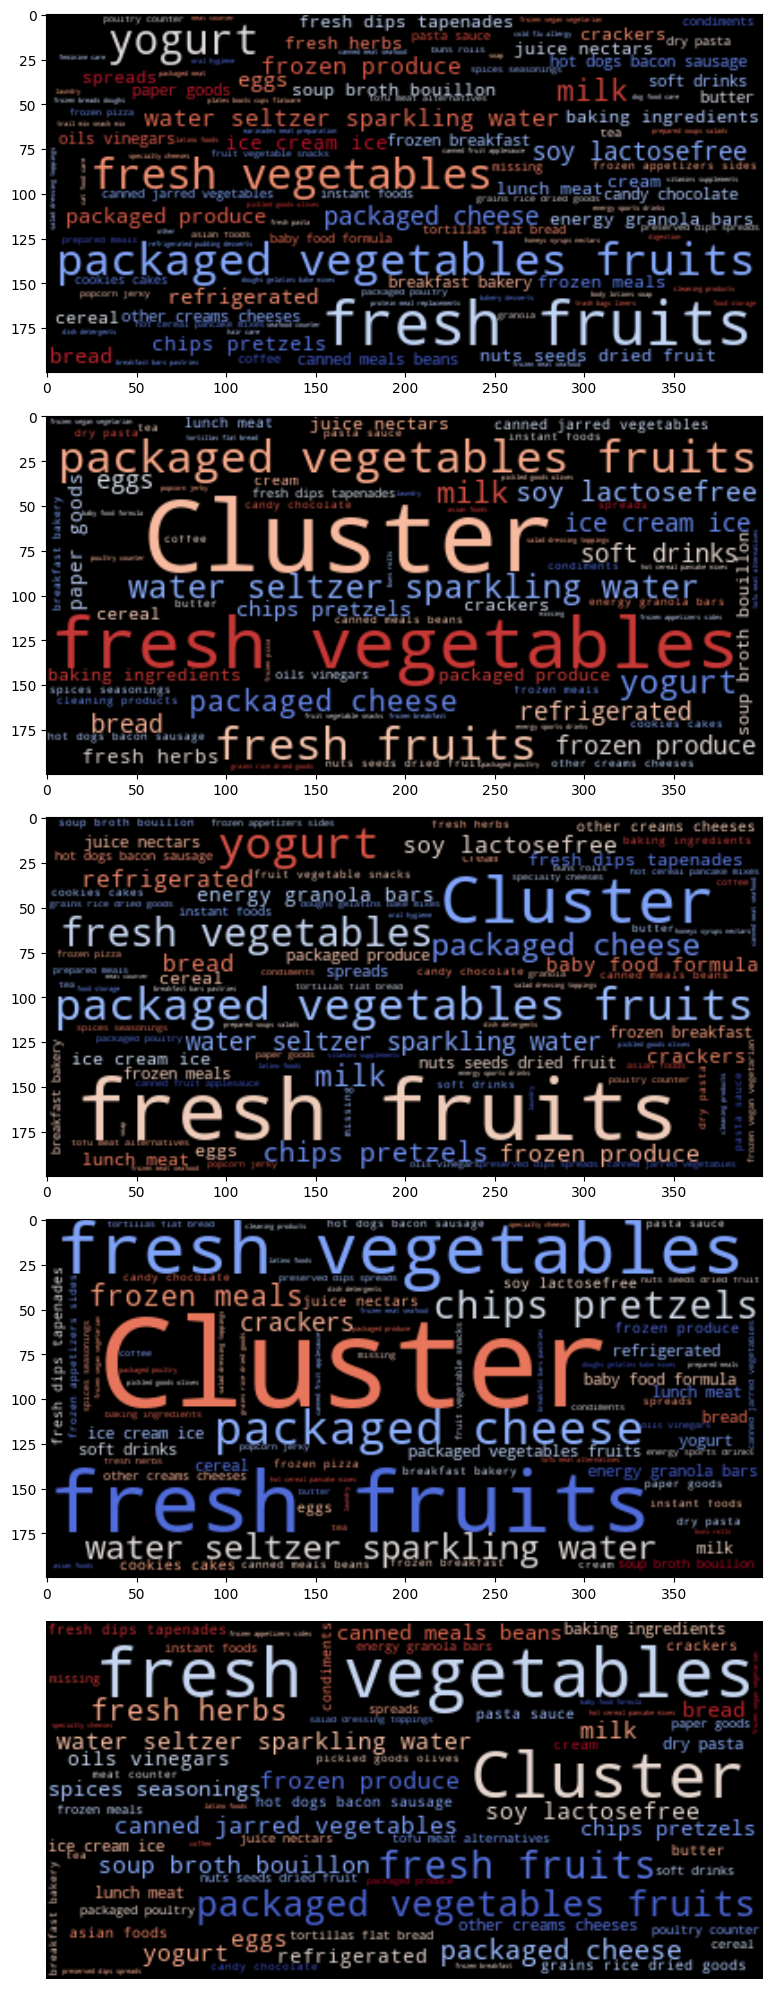

In [ ]:
clust = cust_aisle.groupby('Cluster')
f, a = plt.subplots(nrows=5, sharex=False, figsize=(10, 20), dpi=100)
wcloud = WordCloud(colormap="coolwarm")
for k, ax in zip(clust.groups.keys(), a.flatten()):
  wcloud.generate_from_frequencies(clust.get_group(k).sum())
  ax.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

---
# Market Basket Analysis
---

## Pre-processing Data

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, fpmax, association_rules

### Join Aisles, Departments and Products into a single DataDrame for ease of use.

In [ ]:
products=pd.read_csv('products.csv').merge(pd.read_csv('aisles.csv'), on='aisle_id').merge(pd.read_csv('departments.csv'), on='department_id')
products.drop(['aisle_id', 'department_id'], 1, inplace=True)
products.head()

### Merge Orders with Product orders for User_IDs

In [ ]:
df = pd.concat([pd.read_csv('order_products__train.csv'), pd.read_csv('order_products__prior.csv')], 
               axis=0, sort=False).reset_index(drop=True)

orders = pd.read_csv('orders.csv').merge(df, on='order_id')

orders.drop(['eval_set', 'order_number', 'order_dow', 
             'order_hour_of_day', 'days_since_prior_order', 
             'add_to_cart_order', 'reordered'], 
            axis=1, inplace=True)

orders.head()

### Using a Subset of 10 Users to create a working model

In [ ]:
subdf = orders[orders.user_id<=11]
for key, group in subdf.groupby('user_id'):
  user_df = group.merge(products, on='product_id').drop('product_id', 1)
  break

### Every User's Shopping List

In [ ]:
transactions=[]
for key, group in tqdm(subdf.groupby('user_id')):
  user_df = group.merge(products, on='product_id').drop('product_id', 1)
  # items = list(set([item for item in user_df.product_name]))
  transactions.append(sorted(set([item for item in user_df.product_name])))

### Shopping List to Encoded Dataframe 

In [ ]:
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
transactions = pd.DataFrame(te_array.astype("int"), columns=te.columns_, index = subdf.user_id.unique())
transactions.head()

### Generating Frequent Itemsets

In [ ]:
frequent_itemsets = apriori(transactions, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets.itemsets.apply(lambda x: len(x))
round(frequent_itemsets, 3)

## Generating and Filtering Results for Association Rules
---

### Compute ***Support***
```
> support(A→C) = support(A ∪ C)
```
Measure the abundance or frequency of an item in a database.

In [ ]:
association_rules(frequent_itemsets, support_only=True, min_threshold=0.1).dropna(axis=1)

### **Confidence** as a threshold metric
```
confidence(A→C) = support(A→C)/support(A)
```
Probability of seeing the consequent (Butter) in a transaction given that it also contains the antecedent (Bread).

In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

### **Lift** as a threshold metric
```
lift(A→C) = confidence(A→C)/support(C)
```
Measure how much more often the antecedent (Bread) and consequent (Butter) of a rule A->C occur together than we would expect if they were statistically independent. 
If A and C are independent, the Lift score will be exactly 1.

In [ ]:
association_rules(frequent_itemsets, metric="lift", min_threshold=3)

### **Leverage** as a threshold metric
```
levarage(A→C) = support(A→C)−support(A)×support(C)
```
Difference between the observed frequency of A (Bread) and C (Butter) appearing together and the frequency that would be expected if A (Bread) and C (Butter) were independent

In [ ]:
association_rules(frequent_itemsets, metric="leverage", min_threshold=0.2)

### **Conviction** as a threshold metric
```
conviction(A→C)=1−support(C)/1−confidence(A→C)
```
A high conviction value means that the consequent (Butter) is highly depending on the antecedent (Bread).

In [ ]:
association_rules(frequent_itemsets, metric="conviction")